# ML (Multi‑source) — Prédiction du **prix de location** (Avito + Mubawab)

Ce notebook est le **fichier ML final** pour la partie *Location* : il utilise le dataset fusionné `location_all_sources.csv`
et entraîne un modèle **GradientBoostingRegressor** (avec comparaison à d’autres modèles).

## Objectifs
1. Charger et préparer les données fusionnées (**Avito + Mubawab**)
2. Normaliser les villes (français / arabe) pour éviter les doublons
3. Appliquer des filtres métier (prix/surface/prix_m²) + traitement des valeurs aberrantes
4. Entraîner plusieurs modèles et comparer les performances (**R², RMSE, MAE**)
5. Garder **Gradient Boosting** comme modèle final et interpréter ses résultats :
   - performances sur *log(prix)* et retour en **DH**
   - graphiques (réel vs prédit, erreurs)
   - importance des variables (feature importances)

> **Remarque importante :** on applique une transformation `log1p(prix)` (pratique standard en immobilier) pour stabiliser la variance et réduire l’effet des valeurs extrêmes.


## 1) Imports & chargement des données


In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

# ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Graphiques (matplotlib uniquement)
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 60)

DATA_PATH = Path("..") / "data" / "clean_data" / "location_all_sources.csv"
assert DATA_PATH.exists(), f"❌ Dataset fusionné introuvable: {DATA_PATH}"

df = pd.read_csv(DATA_PATH, encoding="utf-8-sig")
print("Shape:", df.shape)
df.head()


Shape: (15856, 9)


,ville,prix,surface,quartier,type_bien,nb_chambres,nb_salle_de_bain,url_annonce,source
0,Casablanca,20000.0,48.0,Maarif,Appartement,5,1,https://www.avito.ma/fr/maarif/appartements/__...,Avito
1,Tanger,6500.0,90.0,Castilla,Appartement,4,1,https://www.avito.ma/fr/castilla/appartements/...,Avito
2,Casablanca,17000.0,155.0,Racine,Appartement,3,1,https://www.avito.ma/fr/racine/appartements/CM...,Avito
3,Casablanca,2300.0,56.0,Oulfa,Appartement,3,1,https://www.avito.ma/fr/oulfa/appartements/App...,Avito
4,Casablanca,5500.0,90.0,Route d'Azemmour,Appartement,3,1,https://www.avito.ma/fr/route_d_azemmour/appar...,Avito


## 2) Normalisation des villes (multi‑langue)


In [2]:
def normalize_city(v):
    """Unifie les noms de villes (ex: 'الدار البيضاء' -> 'Casablanca')."""
    if pd.isna(v):
        return None
    v = str(v).strip().lower()

    mapping = {
        # Casablanca
        "casablanca": "Casablanca",
        "casa": "Casablanca",
        "الدار البيضاء": "Casablanca",

        # Rabat
        "rabat": "Rabat",
        "الرباط": "Rabat",

        # Marrakech
        "marrakech": "Marrakech",
        "marrakesh": "Marrakech",
        "مراكش": "Marrakech",

        # Tanger
        "tanger": "Tanger",
        "tangier": "Tanger",
        "طنجة": "Tanger",
    }
    return mapping.get(v, v.title())

# Application
df["ville"] = df["ville"].apply(normalize_city)

# Vérification : on ne doit plus voir les versions arabes séparées
df["ville"].value_counts().head(10)


ville
Casablanca    8355
Marrakech     3322
Rabat         2238
Tanger        1941
Name: count, dtype: int64

## 3) Préparation du dataset ML (features/target + types)


In [3]:
# Features utilisées (on ajoute 'source' pour capturer l'effet plateforme)
features = ["ville", "type_bien", "surface", "nb_chambres", "nb_salle_de_bain", "source"]
target = "prix"

df_ml = df[features + [target]].copy()

# Conversion de sécurité des numériques
for c in ["surface", "nb_chambres", "nb_salle_de_bain", "prix"]:
    df_ml[c] = pd.to_numeric(df_ml[c], errors="coerce")

# On garde uniquement les lignes complètes sur les variables nécessaires au ML
df_ml = df_ml.dropna().reset_index(drop=True)

print("Dataset ML (avant filtres):", df_ml.shape)
df_ml.head()


Dataset ML (avant filtres): (15856, 7)


,ville,type_bien,surface,nb_chambres,nb_salle_de_bain,source,prix
0,Casablanca,Appartement,48.0,5,1,Avito,20000.0
1,Tanger,Appartement,90.0,4,1,Avito,6500.0
2,Casablanca,Appartement,155.0,3,1,Avito,17000.0
3,Casablanca,Appartement,56.0,3,1,Avito,2300.0
4,Casablanca,Appartement,90.0,3,1,Avito,5500.0


## 4) Filtres métier + cohérence (prix/surface/prix_m²) + outliers


In [4]:
# 4.1 Filtre métier (location)
# - prix mensuel plausible (DH)
df_ml = df_ml[df_ml["prix"].between(500, 100_000)].reset_index(drop=True)

# - surface plausible (m²)
df_ml = df_ml[df_ml["surface"].between(10, 1000)].reset_index(drop=True)

# 4.2 Cohérence via prix au m²
df_ml["prix_m2"] = df_ml["prix"] / df_ml["surface"]
df_ml = df_ml[df_ml["prix_m2"].between(10, 2000)].reset_index(drop=True)

# 4.3 Outliers statistiques (couper 1% et 99%)
q1 = df_ml["prix"].quantile(0.01)
q99 = df_ml["prix"].quantile(0.99)
df_ml = df_ml[df_ml["prix"].between(q1, q99)].reset_index(drop=True)

print("Dataset ML (après filtres):", df_ml.shape)
df_ml[["prix", "surface", "prix_m2"]].describe()


Dataset ML (après filtres): (15474, 8)


,prix,surface,prix_m2
count,15474.000000,15474.000000,15474.000000
mean,9824.504037,119.396673,92.622804
std,8029.565832,121.452158,51.043163
min,1300.000000,10.000000,10.000000
25%,5000.000000,60.000000,59.523810
50%,7500.000000,85.000000,84.983660
75%,12000.000000,120.000000,118.181818
max,50000.000000,1000.000000,1190.000000


## 5) Transformation de la cible : `log(prix)`


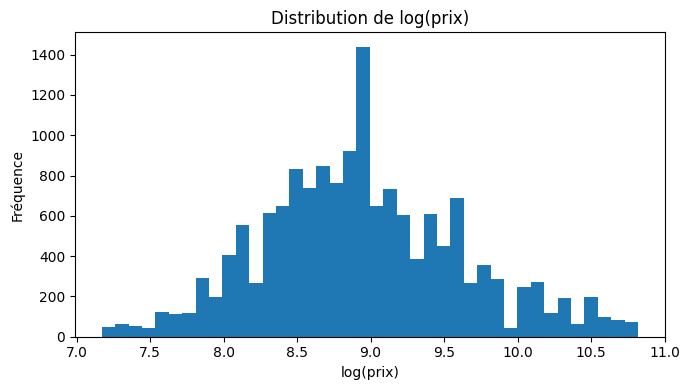

In [5]:
# On apprend sur log(prix) pour stabiliser la variance
df_ml["log_prix"] = np.log1p(df_ml["prix"])

# Aperçu distribution (log_prix)
plt.figure(figsize=(7,4))
plt.hist(df_ml["log_prix"], bins=40)
plt.title("Distribution de log(prix)")
plt.xlabel("log(prix)")
plt.ylabel("Fréquence")
plt.tight_layout()
plt.show()


## 6) Split train/test + Preprocessing (encodage + scaling)


In [6]:
X = df_ml[features]
y = df_ml["log_prix"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

num_features = ["surface", "nb_chambres", "nb_salle_de_bain"]
cat_features = ["ville", "type_bien", "source"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
    ]
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (12379, 6) Test: (3095, 6)


## 7) Entraînement & comparaison de plusieurs modèles


In [7]:
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "RandomForest": RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
}

results = []
fitted_pipes = {}

for name, model in models.items():
    pipe = Pipeline([("prep", preprocessor), ("model", model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    mae_log = mean_absolute_error(y_test, y_pred)
    rmse_log = (mean_squared_error(y_test, y_pred)) ** 0.5
    r2_log = r2_score(y_test, y_pred)

    results.append({
        "Model": name,
        "MAE_log": mae_log,
        "RMSE_log": rmse_log,
        "R2_log": r2_log
    })
    fitted_pipes[name] = pipe

results_df = pd.DataFrame(results).sort_values("R2_log", ascending=False)
results_df


,Model,MAE_log,RMSE_log,R2_log
3,GradientBoosting,0.297019,0.388366,0.666564
2,RandomForest,0.297607,0.395958,0.653399
1,Ridge,0.379290,0.481485,0.487496
0,LinearRegression,0.379291,0.481488,0.487489


### Interprétation rapide des résultats (sur log(prix))
- **R²_log** : proportion de variance expliquée (plus c'est grand, mieux c'est)
- **RMSE_log** / **MAE_log** : erreurs moyennes sur l'échelle log (plus petit = mieux)




## 8) Performance du meilleur modèle en **DH** (retour à l'échelle réelle)


In [8]:
best_name = results_df.iloc[0]["Model"]
best_pipe = fitted_pipes[best_name]

print("Meilleur modèle:", best_name)

# Prédictions sur log(prix)
pred_log = best_pipe.predict(X_test)

# Retour en DH
pred_prix = np.expm1(pred_log)
true_prix = np.expm1(y_test)

mae_dh = mean_absolute_error(true_prix, pred_prix)
rmse_dh = (mean_squared_error(true_prix, pred_prix)) ** 0.5
r2_dh = r2_score(true_prix, pred_prix)  # (indicatif) sur l'échelle DH

print("MAE (DH):", round(mae_dh, 2))
print("RMSE (DH):", round(rmse_dh, 2))
print("R2 (DH)  :", round(r2_dh, 4), "(indicatif)")


Meilleur modèle: GradientBoosting
MAE (DH): 2634.65
RMSE (DH): 4077.61
R2 (DH)  : 0.717 (indicatif)


## 9) Graphiques d'évaluation (Réel vs Prédit + erreurs)


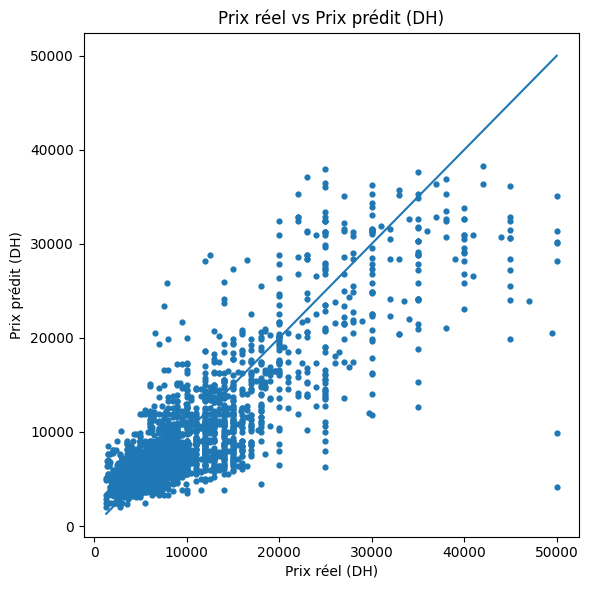

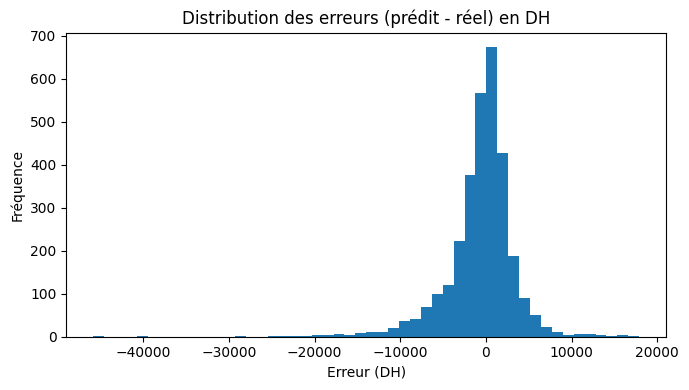

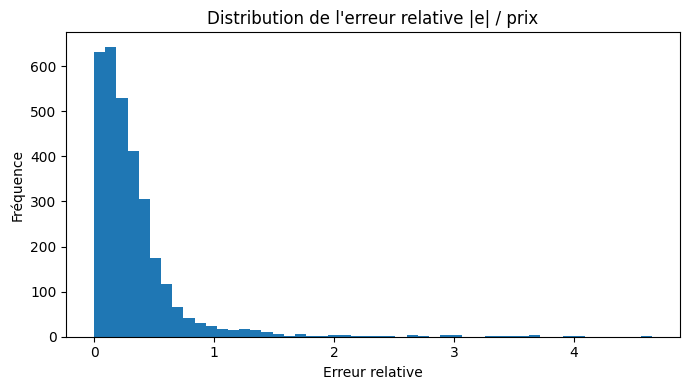

Erreur relative médiane: 0.235


In [9]:
# 9.1 Réel vs Prédit
plt.figure(figsize=(6,6))
plt.scatter(true_prix, pred_prix, s=12)
plt.title("Prix réel vs Prix prédit (DH)")
plt.xlabel("Prix réel (DH)")
plt.ylabel("Prix prédit (DH)")

# diagonale y=x
min_v = float(min(true_prix.min(), pred_prix.min()))
max_v = float(max(true_prix.max(), pred_prix.max()))
plt.plot([min_v, max_v], [min_v, max_v])
plt.tight_layout()
plt.show()

# 9.2 Distribution des erreurs (résidus)
residuals = pred_prix - true_prix
plt.figure(figsize=(7,4))
plt.hist(residuals, bins=50)
plt.title("Distribution des erreurs (prédit - réel) en DH")
plt.xlabel("Erreur (DH)")
plt.ylabel("Fréquence")
plt.tight_layout()
plt.show()

# 9.3 Erreur relative (utile pour l'immobilier)
rel_err = np.abs(residuals) / np.maximum(true_prix, 1)
plt.figure(figsize=(7,4))
plt.hist(rel_err, bins=50)
plt.title("Distribution de l'erreur relative |e| / prix")
plt.xlabel("Erreur relative")
plt.ylabel("Fréquence")
plt.tight_layout()
plt.show()

print("Erreur relative médiane:", round(np.median(rel_err), 3))


## 10) Importance des variables (Feature Importances)

GradientBoostingRegressor fournit `feature_importances_` (importance globale des variables après encodage).
On affiche :
- Top variables numériques (surface, chambres, sdb)
- Top catégories (ville, type, source) après OneHotEncoding


In [10]:
# On extrait les noms de features après le preprocessing
ohe = best_pipe.named_steps["prep"].named_transformers_["cat"]
cat_names = ohe.get_feature_names_out(cat_features)
feature_names = num_features + list(cat_names)

# Importance (si le modèle expose feature_importances_)
model = best_pipe.named_steps["model"]
if hasattr(model, "feature_importances_"):
    importances = model.feature_importances_
    fi = pd.DataFrame({"feature": feature_names, "importance": importances})
    fi = fi.sort_values("importance", ascending=False)

    fi.head(20)


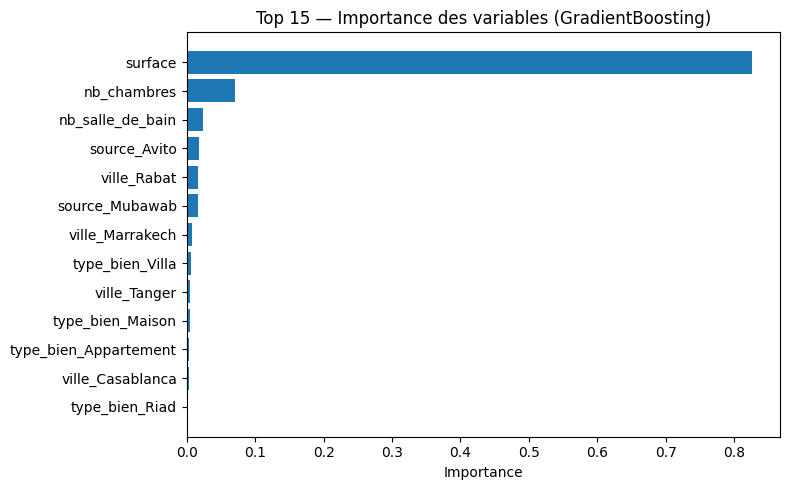

In [11]:
# Graphique Top 15
top = fi.head(15).sort_values("importance")
plt.figure(figsize=(8,5))
plt.barh(top["feature"], top["importance"])
plt.title("Top 15 — Importance des variables (GradientBoosting)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


## 11) Comparaison claire 


In [ ]:

report_table = results_df.copy()
report_table["MAE_log"] = report_table["MAE_log"].round(3)
report_table["RMSE_log"] = report_table["RMSE_log"].round(3)
report_table["R2_log"] = report_table["R2_log"].round(3)
report_table


,Model,MAE_log,RMSE_log,R2_log
3,GradientBoosting,0.297,0.388,0.667
2,RandomForest,0.298,0.396,0.653
1,Ridge,0.379,0.481,0.487
0,LinearRegression,0.379,0.481,0.487




> Nous avons évalué plusieurs modèles de régression sur la prédiction du prix de location (après transformation logarithmique du prix).  
> Les modèles non linéaires (Random Forest et Gradient Boosting) surpassent les modèles linéaires, ce qui confirme la présence de relations non linéaires entre les caractéristiques du bien et son loyer.  
> Le modèle **Gradient Boosting** obtient les meilleures performances (R²_log le plus élevé) et est retenu comme modèle final.  
> Après retour à l'échelle réelle (DH), le modèle fournit une estimation directement interprétable par un utilisateur.


In [13]:
# ============================================
# SAUVEGARDE DU MODÈLE FINAL (PIPELINE COMPLET)
# ============================================

import os
import pickle
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# 1) Récupérer le meilleur modèle (déjà entraîné)
best_name = results_df.iloc[0]["Model"]
best_pipe = fitted_pipes[best_name]

# 2) Évaluation sur le jeu de test (log)
y_test_pred_log = best_pipe.predict(X_test)

r2_test_log = r2_score(y_test, y_test_pred_log)
rmse_test_log = mean_squared_error(y_test, y_test_pred_log) ** 0.5
mae_test_log = mean_absolute_error(y_test, y_test_pred_log)

# 3) Retour à l’échelle réelle (DH)
y_test_real = np.expm1(y_test)
y_test_pred_real = np.expm1(y_test_pred_log)

mae_dh = mean_absolute_error(y_test_real, y_test_pred_real)
rmse_dh = mean_squared_error(y_test_real, y_test_pred_real) ** 0.5
mape_dh = np.mean(
    np.abs(y_test_real - y_test_pred_real) / np.maximum(y_test_real, 1)
) * 100

# 4) Sauvegarde du pipeline complet
os.makedirs("../models", exist_ok=True)

model_path = "../models/location_gradient_boosting_pipeline.pkl"
with open(model_path, "wb") as f:
    pickle.dump(best_pipe, f)

# 5) Sauvegarde d’un résumé des performances
summary_df = pd.DataFrame([{
    "model_name": best_name,
    "r2_test_log": r2_test_log,
    "mae_test_log": mae_test_log,
    "rmse_test_log": rmse_test_log,
    "mae_test_dh": mae_dh,
    "rmse_test_dh": rmse_dh,
    "mape_test_dh": mape_dh,
    "date_training": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "train_samples": len(X_train),
    "test_samples": len(X_test),
}])

summary_path = "../models/location_model_performance_summary.csv"
summary_df.to_csv(summary_path, index=False, encoding="utf-8-sig")

# 6) Affichage final
print("="*60)
print("MODÈLE FINAL SAUVEGARDÉ AVEC SUCCÈS")
print("="*60)
print(f"📦 Modèle (pipeline) : {model_path}")
print(f"📊 Résumé performances : {summary_path}")

print("\nPERFORMANCES TEST :")
print(f"• R² (log)   : {r2_test_log:.4f}")
print(f"• MAE (DH)   : {mae_dh:,.0f} DH")
print(f"• RMSE (DH)  : {rmse_dh:,.0f} DH")
print(f"• MAPE (DH)  : {mape_dh:.2f} %")
print("="*60)


MODÈLE FINAL SAUVEGARDÉ AVEC SUCCÈS
📦 Modèle (pipeline) : ../models/location_gradient_boosting_pipeline.pkl
📊 Résumé performances : ../models/location_model_performance_summary.csv

PERFORMANCES TEST :
• R² (log)   : 0.6666
• MAE (DH)   : 2,635 DH
• RMSE (DH)  : 4,078 DH
• MAPE (DH)  : 32.43 %
